### Как проверить корректность критерия в A/B тестах

Допустим, мы работаем в онлайн-магазине с доставкой. Хотим исследовать, как новый алгоритм ранжирования товаров на сайте 
влияет на среднюю выручку с покупателя за неделю. 

Продолжительность эксперимента – одна неделя. 

Ожидаемый эффект равен +100 рублей. 

Допустимая вероятность ошибки первого рода равна 0.1, второго рода – 0.2.

$n>\frac{\left[\Phi^{-1}(1-\alpha / 2)+\Phi^{-1}(1-\beta)\right]^2\left(\sigma_A^2+\sigma_B^2\right)}{\varepsilon^2}$

In [1]:
import numpy as np
from scipy import stats
from tqdm.auto import tqdm
import seaborn as sns



alpha = 0.1                     # допустимая вероятность ошибки I рода
beta = 0.2                      # допустимая вероятность ошибки II рода
mu_control = 2500               # средняя выручка с пользователя в контрольной группе
effect = 100                    # ожидаемый размер эффекта
mu_pilot = mu_control + effect  # средняя выручка с пользователя в экспериментальной группе
std = 800                       # стандартное отклонение

# исторические данные выручки для 10000 клиентов
values = np.random.normal(mu_control, std, 10000)

def estimate_sample_size(effect, std, alpha, beta):
    """Оценка необходимого размер групп."""
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
    return sample_size

estimated_std = np.std(values)
sample_size = estimate_sample_size(effect, estimated_std, alpha, beta)
print(f'оценка необходимого размера групп = {sample_size}')

оценка необходимого размера групп = 789


### Функция `tt_ind_solve_power` возвращает значение для одного из 4 аргументов, который пропущен (None). 


In [3]:
## с помощью готовой функции

import statsmodels.stats.power as smp
n = smp.tt_ind_solve_power(effect_size = (mu_pilot - mu_control) / np.std(values) , alpha = alpha, power = 1 - beta, alternative='two-sided')
n

790.294207678278

In [4]:
# Какая мощность критерия будет в выборке из n наблюдений, 
# при условии, что величина эффекта = effect c уровнем значимости alpha

power = smp.tt_ind_solve_power(effect_size=(mu_pilot - mu_control) / np.std(values), nobs1=n, alpha=alpha, alternative='two-sided')
power

0.8000000009645165

In [5]:
# Какова величина эффекта будет при рассчете теста, при заранее заданных
# величинах альфа и величины мощности 
print(f"Истинный эффект изначально: {(mu_pilot - mu_control) / np.std(values)}")
print(f"Рассчитанный эффект: {smp.tt_ind_solve_power(nobs1 = n, alpha = alpha, power = power)}")

Истинный эффект изначально: 0.1251352276947522
Рассчитанный эффект: 0.1251343061951009


In [6]:
effects = []
sample_sizes = []

for i in tqdm(range(50,2000)):
    # Какова величина эффекта будет при рассчете теста, при заранее заданных
    # величинах альфа и величины мощности 
    effects.append(smp.tt_ind_solve_power(nobs1 = i, alpha = alpha, power = power)) 
    sample_sizes.append(i)

  0%|          | 0/1950 [00:00<?, ?it/s]

Text(0, 0.5, 'Effect Amount')

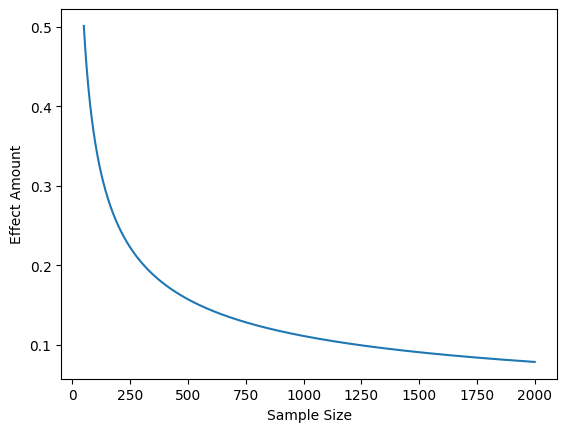

In [7]:
viz = sns.lineplot(x=sample_sizes, y=effects)
viz.set_xlabel("Sample Size")
viz.set_ylabel("Effect Amount")

#### Чем больше выборка, тем более малый эффект мы можем заметить

### Оценка ошибок 1 и 2 рода для определенного критерия

Посмотрим, как оценить вероятности ошибок первого и второго рода . С помощью численных синтетических А/А и А/Б экспериментов оценим вероятности ошибок и построим доверительные интервалы:



In [12]:
def run_synthetic_experiments(values, sample_size, effect=0, n_iter=10000):
    """Проводим синтетические эксперименты, возвращаем список p-value."""
    pvalues = []
    for _ in range(n_iter):
        a, b = np.random.choice(values, size=(2, sample_size,), replace=False)
        b += effect
        pvalue = stats.ttest_ind(a, b).pvalue
        pvalues.append(pvalue)
    return np.array(pvalues)

def print_estimated_errors(pvalues_aa, pvalues_ab, alpha):
    """Оценивает вероятности ошибок."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(pvalues_aa))
    ci_second = estimate_ci_bernoulli(estimated_second_type_error, len(pvalues_ab))
    print(f'оценка вероятности ошибки I рода = {estimated_first_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')
    print(f'оценка вероятности ошибки II рода = {estimated_second_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_second[0]:0.4f}, {ci_second[1]:0.4f}]')

def estimate_ci_bernoulli(p, n, alpha=0.05):
    """Доверительный интервал для Бернуллиевской случайной величины."""
    t = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    std_n = np.sqrt(p * (1 - p) / n)
    return p - t * std_n, p + t * std_n

pvalues_aa = run_synthetic_experiments(values, sample_size, effect=0)
pvalues_ab = run_synthetic_experiments(values, sample_size, effect=effect)
print_estimated_errors(pvalues_aa, pvalues_ab, alpha)

оценка вероятности ошибки I рода = 0.1026
  доверительный интервал = [0.0967, 0.1085]
оценка вероятности ошибки II рода = 0.1954
  доверительный интервал = [0.1876, 0.2032]


Оценки вероятностей ошибок примерно равны 0.1 и 0.2, как и должно быть. Всё верно, тест Стьюдента на этих данных работает корректно.



## Распределение p-value через функцию Распределения

### Если верна нулевая гипотеза

Для любого $\alpha \in[0,1]$ выполняется $\mathbb{P}\left(\right.$ pvalue $\left.<\alpha \mid H_0\right)=\alpha$

Заметим, что в левой части равенства записано выражение для функции распределения p-value.
Из равенства следует, что функция распределения p-value в точке X равна X для любого X от 0 до 1. 

Эта функция распределения является функцией распределения равномерного распределения от 0 до 1

### Если верна альтернативная гипотеза

Ошибка 2 рода : $\mathbb{P}\left(\right.$ pvalue $\left.\geq \alpha \mid H_1\right)=\beta$

$\mathbb{P}\left(\right.$ pvalue $\left.<\alpha \mid H_1\right)=1-\beta$

Получается, график функции распределения p-value при верности альтернативной гипотезы должен проходить через точку $\mathbb{[\alpha, 1 - \beta]}$, 

где $\mathbb{\alpha,\beta}$ – допустимые вероятности ошибок конкретного эксперимента.

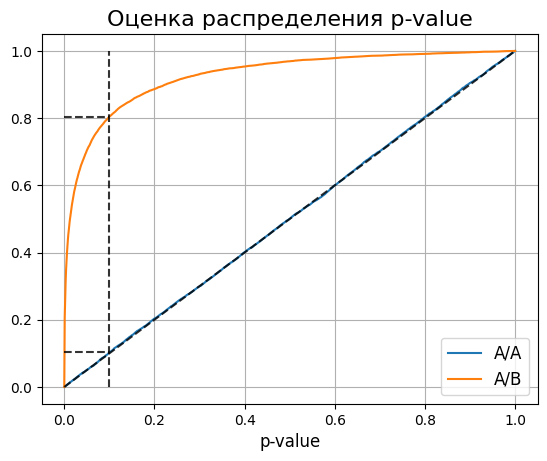

In [13]:
import matplotlib.pyplot as plt

def plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, beta):
    """Рисует графики распределения p-value."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    y_one = estimated_first_type_error
    y_two = 1 - estimated_second_type_error
    X = np.linspace(0, 1, 1000)
    Y_aa = [np.mean(pvalues_aa < x) for x in X]
    Y_ab = [np.mean(pvalues_ab < x) for x in X]

    plt.plot(X, Y_aa, label='A/A')
    plt.plot(X, Y_ab, label='A/B')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, alpha], [y_one, y_one], '--k', alpha=0.8)
    plt.plot([0, alpha], [y_two, y_two], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)

    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, beta)

P-value для синтетических А/А тестах действительно оказалось распределено равномерно от 0 до 1, 
а для синтетических А/Б тестов проходит через точку  $\mathbb{[\alpha, 1 - \beta]}$



- диагональная из точки [0, 0] в точку [1, 1] – это функция распределения равномерного распределения на отрезке от 0 до 1, по ней можно визуально оценивать равномерность распределения p-value;

- вертикальная линия с x=\alpha – пороговое значение p-value, по которому определяем отвергать нулевую гипотезу или нет. Проекция на ось ординат точки пересечения вертикальной линии с функцией распределения p-value для А/А тестов – это вероятность ошибки первого рода. Проекция точки пересечения вертикальной линии с функцией распределения p-value для А/Б тестов – это мощность теста (мощность = 1 - \beta). 

- две горизонтальные линии – проекции на ось ординат точки пересечения вертикальной линии с функцией распределения p-value для А/А и А/Б тесто

### Некорректный критерий

Тест стьюдента сверху правильно зафиксировал ошибку первого и второго рода. 

Может быть, все критерии всегда работаю корректно, и нет смысла каждый раз проверять вероятности ошибок?

Допустим, мы решили увеличить продолжительность эксперимента до 2-х недель.

Для каждого пользователя будем вычислять стоимость покупок за первую неделю и стоимость покупок за второю неделю.

Полученные стоимости будем передавать в тест Стьюдента для проверки значимости отличий. 

Положим, что поведение пользователей повторяется от недели к неделе, и стоимости покупок одного пользователя совпадают.

оценка вероятности ошибки I рода = 0.2454
  доверительный интервал = [0.2370, 0.2538]
оценка вероятности ошибки II рода = 0.0889
  доверительный интервал = [0.0833, 0.0945]


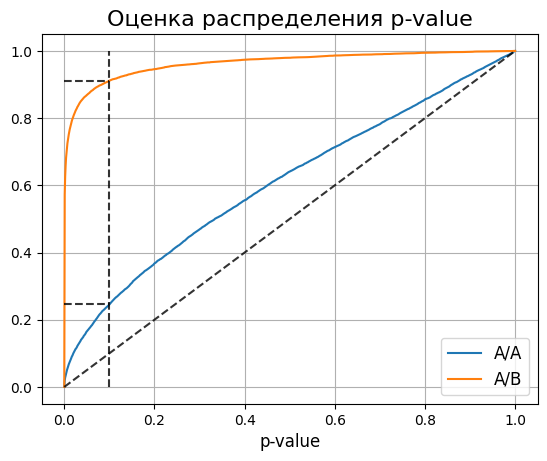

In [14]:
def run_synthetic_experiments_two(values, sample_size, effect=0, n_iter=10000):
    """Проводим синтетические эксперименты на двух неделях."""
    pvalues = []
    for _ in range(n_iter):
        a, b = np.random.choice(values, size=(2, sample_size,), replace=False)
        b += effect
        # дублируем данные
        a = np.hstack((a, a,))
        b = np.hstack((b, b,))
        pvalue = stats.ttest_ind(a, b).pvalue
        pvalues.append(pvalue)
    return np.array(pvalues)

pvalues_aa = run_synthetic_experiments_two(values, sample_size)
pvalues_ab = run_synthetic_experiments_two(values, sample_size, effect=effect)
print_estimated_errors(pvalues_aa, pvalues_ab, alpha)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, beta)

В этом примере тест Стьюдента работает некорректно, так как данные зависимые (стоимости покупок одного человека зависимы). 
Если бы мы сразу не догадались про зависимость данных, то оценка вероятностей ошибок помогла бы нам понять, что такой тест некорректен.

Таким образом:

- корректный критерий – это критерий, у которого вероятности ошибок первого и второго рода равны допустимым вероятностям ошибок первого и второго рода соответственно;

- чтобы критерий контролировал вероятность ошибки первого рода для любого уровня значимости, необходимо и достаточно, чтобы p-value при верности нулевой гипотезы было распределено равномерно от 0 до 1.